* This notebook implements the VAE model in [Kingma (2013)](https://arxiv.org/abs/1312.6114).

## Variational Auto-encoder

### Motivation

In addition to the values of observable and of its latent variable, we are to encode the uncertainties of them also.

### Definitions

* Let $X$ be the observed random variable and $Z$ the latent random variable. Let

  \begin{equation}
    Z \sim P_{Z}
  \end{equation}

  be some given prior.
  
* And let

  \begin{equation}
    X \mid Z \sim P_{X \mid Z; \phi}
  \end{equation}

  for some distribution in a family parameterized by $\phi$.

For instance, if $X \in \mathbb{R}$, it is general to assume a multivariate Gaussian distribution, diagonalized or semi-diagonalized, then we have

\begin{equation}
  X \mid Z \sim \mathcal{N} \left( \mu(Z; \phi_1), \sigma(Z; \phi_2) \right),
\end{equation}

for some universality functions $\mu(\cdot; \phi_2)$ and $\sigma(\cdot; \phi_2)$ and $\phi := (\phi_1, \phi_2)$.

### Variational Inference

Utilization of the dataset of $x$ forces us to employ some distribution $q(z \mid x)$ (to be determined) to fit $p(z \mid x)$ (and if the dataset is of $z$, then we are forced to $p(x \mid z)$ instead), then we have the bound by KL-divergence

\begin{equation}
  \text{KL} \left( q(z \mid x) \| p(z \mid x) \right)
  = \text{KL} \left( q(z \mid x) \| p(x, z) \right) + \ln p(x)
  \geq 0.
\end{equation}

Thus, a loss

\begin{align}
  L(x)
  & := \text{KL} \left( q(z \mid x) \| p(y, z) \right) \\
  & = \mathbb{E}_{z \sim q(z \mid x)} \left[
         \ln q(z \mid x) - \ln p(x \mid z) - \ln p(z) \right] \\
  & \geq - \ln p(x).
\end{align}

The equality can be reached if and only if $q(z \mid x) = p(z \mid x)$.

### Evaluation of Inference

The evaluation of this fitting is comparing the $\ln p(x)$ and the $-L(x)$. Given any $p(x \mid z)$, we have

\begin{align}
  p(x) & = \int dz p(x \mid z) p(z) \\
       & = \mathbb{E}_{z \sim p(z)} \left[ p(x \mid z) \right].
\end{align}

### Relation with Autoencoder

* The $\mathbb{E}_{z \sim q(z \mid x)} \left[ - \ln p(x \mid z) \right]$ part can be interpreted as a reconstruction loss.

* The $\mathbb{E}_{z \sim q(z \mid x)} \left[ - \ln p(z) \right]$ part serves as regularization terms.

* It seems that the $\mathbb{E}_{z \sim q(z \mid x)} \left[ \ln q(z \mid x) \right]$ part has no correspondence in auto-encoder.

### Example

In this very example on the MNIST dataset:

\begin{align}
  Z & \sim \mathcal{N} (0, 1); \\
  X \mid Z & \sim \text{Bernoulli}\left( p(z; \theta) \right).
\end{align}

And inference distributions:

\begin{align}
  Z_0 \mid X & \sim \mathcal{N}\left( \mu(x; \phi_1), \sigma(x; \phi_2) \right); \\
  Z \mid Z_0 & \sim T(z_0).
\end{align}

where $Z_0$ obeys the "base inference distribution", as a Gaussian; and $T$ is bijective with universality.

## Implementation

In [28]:
%matplotlib inline

from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd
from tensorflow.contrib.distributions.python.ops import bijectors as tfb
from tensorflow.examples.tutorials.mnist import input_data

# For reproducibility
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

### Functions

In [76]:
def get_p_X_z(z, X_dim, hidden_layers=None,
              name='p_X_z', reuse=None):
  """Returns the distribution of P(X|Z).
  
  X | Z ~ Bernoulli( p(Z) ).
  
  Args:
    z: Tensor of the shape `[batch_size, z_dim]`.
    X_dim: Positive integer.
    hidden_layers: List of positive integers. Defaults to
      `[128, 256, 512]`.
    
  Returns:
    An instance of `tfd.Distribution`, with batch-shape `batch_size`
    and event-shape `X_dim`.
  """
  if hidden_layers is None:
    hidden_layers = [128, 256, 512]
    
  with tf.variable_scope(name, reuse=reuse):
    hidden = z
    for hidden_layer in hidden_layers:
      hidden = tf.layers.dense(hidden, hidden_layer,
                               activation=tf.nn.relu)
    logits = tf.layers.dense(hidden, X_dim, activation=None)

    p_X_z = tfd.Independent(tfd.Bernoulli(logits=logits))
    return p_X_z

In [74]:
def get_q_z_X(X, z_dim, hidden_layers=None, bijectors=None,
              dtype='float32', name='q_z_X', reuse=None):
  """Returns the distribution of Z | X.
  
  Z = bijector(Z_0), and
  Z_0 | X ~ Normal(mu(X;phi), sigma(X;phi)).
  
  Args:
    X: Tensor with shape `[batch_size, X_dim]`.
    z_dim: Positive integer.
    hidden_layers: List of positive integers. Defaults to
      `[512, 256, 128]`.
    bijectors: List of `tfb.Bijector`s. Defaults to an empty
      list.
    
  Returns:
    An instance of `tfd.Distribution`, with batch-shape `batch_size`
    and event-shape `z_dim`.
  """
  if bijectors is None:
    bijectors = []
  if hidden_layers is None:
    hidden_layers = [512, 256, 128]
    
  with tf.variable_scope(name, reuse=reuse):
    hidden = X
    for hidden_layer in hidden_layers:
      hidden = tf.layers.dense(hidden, hidden_layer,
                               activation=tf.nn.relu)
    # Outputs in the fiber-bundle space
    output = tf.layers.dense(hidden, z_dim * 2, activation=None)
    # shape: [batch_size, z_dim]
    mu, log_var = tf.split(output, [z_dim, z_dim], axis=1)
    
    q_z0_X = tfd.MultivariateNormalDiag(mu, tf.exp(log_var))
    chain = tfb.Chain(bijectors)
    q_z_X = tfd.TransformedDistribution(q_z0_X, chain)
    return q_z_X

In [75]:
def get_bijectors(name='bjiectors', reuse=None):
  """Complexify the inference distribution by extra-bijectors like
  normalizing flows.
  
  Returns:
    List of `Bijector`s.
  """
  with tf.variable_scope(name, reuse=reuse):
    bijectors = []
    #return bijectors  # test!
    for i in range(10):
      # Get one bijector
      shift_and_log_scale_fn = \
        tfb.masked_autoregressive_default_template([128])
      # MAP is extremely slow in training. Use IAF instead.
      bijector = tfb.Invert(
          tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn))
      bijectors.append(bijector)
    return bijectors

In [5]:
def get_loss_X(get_q_z_X, get_p_X_z, p_z, reuse=None):
  """L(X) := E_{z ~ q(z|X)} [ log_q(z|X) - log_p(z) - log_p(X|z) ].
  
  Args:
    get_q_z_X: Callable with the signature:
      Args:
        X: Tensor with shape `[batch_size, X_dim]`.
        reuse: Boolean.
      Returns:
        An instance of `tfd.Distribution`, with batch-shape `batch_size`
        and event-shape `z_dim`.
    get_p_X_z: Callable with the signature:
      Args:
        z: Tensor of the shape `[batch_size, z_dim]`.
        reuse: Boolean.
      Returns:
        An instance of `tfd.Distribution`, with batch-shape `batch_size`
        and event-shape `X_dim`.
    p_z: An instance of `tfd.Distribution`, with batch-shape `batch_size`
      and event-shape `z_dim`.
    reuse: If reuse the variables in `get_q_z_X` and `get_p_X_z`.
    
  Returns:
    Callable with the signature:
      Args:
        X: Tensor of the shape `[batch_size, X_dim]`.
      Returns:
        Tensor of the shape `[batch_size]`.
  """
  
  def loss_X(X, name='loss_X'):
    """
    Args:
      X: Tensor of the shape `[batch_size, X_dim]`.

    Returns:
      Tensor of the shape `[batch_size]`.
    """
    with tf.name_scope(name):
      # Get the distribution q(z|X)
      q_z_X = get_q_z_X(X, reuse=reuse)
      
      # Get the distribution p(X|z)
      z_samples = q_z_X.sample()
      p_X_z = get_p_X_z(z_samples, reuse=reuse)
      
      # Compute the tensor of L(X)
      loss_X_tensor = tf.zeros([batch_size])  # initialize.
      # E_{z ~ q(z|X)} [ log_q(z|X) ]
      loss_X_tensor += q_z_X.log_prob(z_samples)
      # E_{z ~ q(z|X)} [ - log_p(z) ]
      loss_X_tensor += -1 * p_z.log_prob(z_samples)
      # E_{z ~ q(z|X)} [ - log_p(X|z) ]
      loss_X_tensor += -1 * p_X_z.log_prob(X)
      return loss_X_tensor
    
  return loss_X

In [58]:
def get_log_p_X(get_p_X_z, p_z, n_samples=100, reuse=None):
  """Returns the function ln p(X) by Monte-Carlo integral.
  
  p(X) = E_{z~p(z)} [ p(X|z) ].
  
  Args:
    get_p_X_z: Callable with the signature:
      Args:
        z: Tensor of the shape `[batch_size, z_dim]`.
        reuse: Boolean.
      Returns:
        An instance of `tfd.Distribution`, with batch-shape `batch_size`
        and event-shape `X_dim`.
    p_z: An instance of `tfd.Distribution`, with batch-shape `batch_size`
      and event-shape `z_dim`.
    n_samples: Positive integer.
    reuse: If reuse the variables in `get_p_X_z`.
    
  Returns:
    Callable with the signature:
      Args:
        X: Tensor of the shape `[batch_size, X_dim]`.
        name: String.
      Returns:
        Tensor of the shape `[batch_size]`.
  """
  
  def log_p_X(X, name='log_p_X'):
    """Returns the tensor of ln p(X).

    Args:
      X: Tensor of the shape `[batch_size, X_dim]`.
      name: String.
      
    Returns:
      Tensor of the shape `[batch_size]`.
    """
    with tf.name_scope(name):
      
      def log_p_X_z(z_sample):
        """Returns the tensor of ln p(X|z)."""
        p_X_z = get_p_X_z(z_sample, reuse=reuse)
        return p_X_z.log_prob(X)  # [batch_size]

      z_samples = p_z.sample(n_samples)  # [n_samples, batch_size, z_dim]
      expected = tf.map_fn(log_p_X_z, z_samples)  # [n_samples, batch_size]
      log_p_X_tensor = (tf.reduce_logsumexp(expected, axis=0) -
                        tf.log(float(n_samples)))
      return log_p_X_tensor
    
  return log_p_X

### Loss

In [7]:
batch_size = 128
X_dim = 28 * 28
X = tf.placeholder(shape=[batch_size, X_dim], dtype='float32', name='X')

In [29]:
z_dim = 64
p_z = tfd.MultivariateNormalDiag(tf.zeros([batch_size, z_dim]), name='p_z')

In [77]:
def _get_q_z_X(X, reuse):
  bijectors = get_bijectors(reuse=reuse)
  #bijectors = []  # test!
  return get_q_z_X(X, z_dim, bijectors=bijectors, reuse=reuse)

def _get_p_X_z(z, reuse):
  return get_p_X_z(z, X_dim=X_dim, reuse=reuse)

loss_X = get_loss_X(_get_q_z_X, _get_p_X_z, p_z, reuse=tf.AUTO_REUSE)
loss_X_tensor = loss_X(X)
loss_X_scalar = tf.reduce_mean(loss_X_tensor)

### Generating

In [10]:
z_samples = tf.placeholder(shape=[batch_size, z_dim],
                           dtype='float32',
                           name='z_samples')
X_samples = _get_p_X_z(z_samples, reuse=tf.AUTO_REUSE).sample()

In [11]:
def get_image(array):
  """
  Args:
    array: Numpy array with shape `[28*28]`.
    
  Returns:
    An image.
  """
  array = 255 * array
  array = array.reshape([28, 28])
  array = array.astype(np.uint8)
  return Image.fromarray(array)

### Training

In [12]:
optimizer = tf.train.AdamOptimizer(epsilon=1e-3)
train_op = optimizer.minimize(loss_X_scalar)

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [68]:
mnist = input_data.read_data_sets('dat/MNIST', one_hot=True)

def get_X_y_batch():
    X_batch, y_batch = mnist.train.next_batch(batch_size)
    # Since X | Y, Z ~ Bernoulli, the observed value of X shall
    # either be 0 or 1,
    X_batch = np.where(X_batch >= 0.5, np.ones_like(X_batch),
                       np.zeros_like(X_batch))
    return X_batch, y_batch

Extracting dat/MNIST/train-images-idx3-ubyte.gz
Extracting dat/MNIST/train-labels-idx1-ubyte.gz
Extracting dat/MNIST/t10k-images-idx3-ubyte.gz
Extracting dat/MNIST/t10k-labels-idx1-ubyte.gz


100%|██████████| 100000/100000 [13:33<00:00, 122.94it/s]


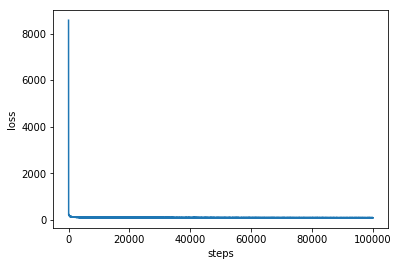

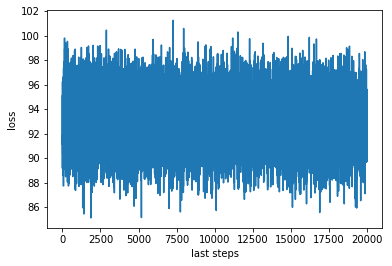

Final loss: 93.02525


In [15]:
loss_vals = []
for i in tqdm(range(100000)):
  X_batch, y_batch = mnist.train.next_batch(batch_size)
  _, loss_val = sess.run([train_op, loss_X_scalar], {X: X_batch})
  if np.isnan(loss_val):
    raise ValueError('Loss has been NaN.')
  loss_vals.append(loss_val)
  
# Visualization
plt.plot(loss_vals)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

# Zoomed in
last_steps = 20000
plt.plot(loss_vals[-last_steps:])
plt.xlabel('last steps')
plt.ylabel('loss')
plt.show()

print('Final loss:', np.mean(loss_vals[-100:]))

In [16]:
z_sample_vals = np.random.normal(size=[batch_size, z_dim])
X_sample_vals = sess.run(X_samples, {z_samples: z_sample_vals})

# Display the results
n_display = 5
for i in range(n_display):
  print('Gnerated:')
  display(get_image(X_sample_vals[i]))
  print()

Gnerated:



Gnerated:



Gnerated:



Gnerated:



Gnerated:


### Effect of Normalizing-flow

* While not employing normalizing flow, 100000 iterations give the final loss about 97.8.
* With 10 normalizing flows, 100000 iterations give the final loss 93.5 (improved 4.3).

In [17]:
np.exp(4)

54.598150033144236

### Evaluation

In [66]:
# Compute the lower bound of loss for any (trained) p(X|z).

log_p_X = get_log_p_X(_get_p_X_z, p_z,
                      n_samples=10**5,
                      reuse=tf.AUTO_REUSE)
log_p_X_tensor = log_p_X(X)
loss_lower_bound = -1 * tf.reduce_mean(log_p_X_tensor)

In [67]:
print(sess.run(loss_lower_bound, {X: X_batch}))

106.46511


It's strange that the lower bound of loss is even greater than the trained loss! And the Monte-Carlo integral is not that in-sensitive to the `n_samples`, as it should be.